## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras.datasets import cifar10

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 
MOMENTUM = 0.95

In [12]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.2, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=3, 
                              verbose=1)

In [13]:
import tensorflow as tf

optimizer_set = [tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 tf.keras.optimizers.Adam(lr=LEARNING_RATE),
                 tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)]
"""Code Here
建立實驗的比較組合
"""

reduce_lr_factor = [0.5, 0.3 , 0.1]
redice_lr_patient = [10,5,2]

In [15]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 10
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 256)               786688    
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer2 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 


49/49 [==============================] - 2s 39ms/step - loss: 1.4636 - accuracy: 0.4897 - val_loss: 1.5911 - val_accuracy: 0.4456 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 2s 40ms/step - loss: 1.4255 - accuracy: 0.5019 - val_loss: 1.5557 - val_accuracy: 0.4510 - lr: 0.0010
Epoch 8/25
49/49 [==============================] - 2s 39ms/step - loss: 1.3925 - accuracy: 0.5140 - val_loss: 1.5407 - val_accuracy: 0.4579 - lr: 0.0010
Epoch 9/25
49/49 [==============================] - 2s 38ms/step - loss: 1.3635 - accuracy: 0.5248 - val_loss: 1.5256 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 10/25
49/49 [==============================] - 2s 40ms/step - loss: 1.3342 - accuracy: 0.5356 - val_loss: 1.5106 - val_accuracy: 0.4652 - lr: 0.0010
Epoch 11/25
49/49 [==============================] - 2s 46ms/step - loss: 1.3089 - accuracy: 0.5435 - val_loss: 1.4921 - val_accuracy: 0.4761 - lr: 0.0010
Epoch 12/25
49/49 [==============================] - 3s 61ms/step - loss: 1.2845 - ac

Epoch 22/25
49/49 [==============================] - 3s 62ms/step - loss: 1.0896 - accuracy: 0.6274 - val_loss: 1.4276 - val_accuracy: 0.4985 - lr: 5.0000e-04
Epoch 23/25
49/49 [==============================] - 3s 58ms/step - loss: 1.0790 - accuracy: 0.6319 - val_loss: 1.4324 - val_accuracy: 0.5015 - lr: 5.0000e-04
Epoch 24/25
48/49 [============================>.] - ETA: 0s - loss: 1.0713 - accuracy: 0.6360
Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
49/49 [==============================] - 3s 58ms/step - loss: 1.0712 - accuracy: 0.6359 - val_loss: 1.4309 - val_accuracy: 0.4977 - lr: 5.0000e-04
Epoch 25/25
49/49 [==============================] - 3s 58ms/step - loss: 1.0585 - accuracy: 0.6393 - val_loss: 1.4286 - val_accuracy: 0.5001 - lr: 2.5000e-04
Numbers of exp: 3, reduce_factor: 0.30, reduce_patient: 10
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Para

Epoch 1/25
49/49 [==============================] - 4s 63ms/step - loss: 2.5835 - accuracy: 0.1867 - val_loss: 2.2335 - val_accuracy: 0.1650 - lr: 2.5000e-04
Epoch 2/25
49/49 [==============================] - 3s 57ms/step - loss: 2.0564 - accuracy: 0.3023 - val_loss: 2.1243 - val_accuracy: 0.2399 - lr: 2.5000e-04
Epoch 3/25
49/49 [==============================] - 3s 60ms/step - loss: 1.8989 - accuracy: 0.3472 - val_loss: 2.0179 - val_accuracy: 0.2847 - lr: 2.5000e-04
Epoch 4/25
49/49 [==============================] - 3s 58ms/step - loss: 1.8098 - accuracy: 0.3742 - val_loss: 1.9172 - val_accuracy: 0.3225 - lr: 2.5000e-04
Epoch 5/25
49/49 [==============================] - 3s 58ms/step - loss: 1.7487 - accuracy: 0.3929 - val_loss: 1.8348 - val_accuracy: 0.3532 - lr: 2.5000e-04
Epoch 6/25
49/49 [==============================] - 3s 56ms/step - loss: 1.7031 - accuracy: 0.4074 - val_loss: 1.7628 - val_accuracy: 0.3739 - lr: 2.5000e-04
Epoch 7/25
49/49 [==============================] - 

Epoch 17/25
49/49 [==============================] - 2s 38ms/step - loss: 1.4616 - accuracy: 0.4894 - val_loss: 1.5916 - val_accuracy: 0.4383 - lr: 2.5000e-04
Epoch 18/25
49/49 [==============================] - 2s 40ms/step - loss: 1.4482 - accuracy: 0.4949 - val_loss: 1.5828 - val_accuracy: 0.4396 - lr: 2.5000e-04
Epoch 19/25
49/49 [==============================] - 2s 39ms/step - loss: 1.4371 - accuracy: 0.4981 - val_loss: 1.5761 - val_accuracy: 0.4399 - lr: 2.5000e-04
Epoch 20/25
49/49 [==============================] - 3s 52ms/step - loss: 1.4242 - accuracy: 0.5033 - val_loss: 1.5699 - val_accuracy: 0.4450 - lr: 2.5000e-04
Epoch 21/25
49/49 [==============================] - 3s 61ms/step - loss: 1.4135 - accuracy: 0.5070 - val_loss: 1.5657 - val_accuracy: 0.4462 - lr: 2.5000e-04
Epoch 22/25
49/49 [==============================] - 3s 57ms/step - loss: 1.4022 - accuracy: 0.5098 - val_loss: 1.5607 - val_accuracy: 0.4487 - lr: 2.5000e-04
Epoch 23/25
49/49 [===========================

Epoch 1/25
49/49 [==============================] - 7s 109ms/step - loss: 2.4880 - accuracy: 0.2045 - val_loss: 2.2335 - val_accuracy: 0.1668 - lr: 2.5000e-04
Epoch 2/25
49/49 [==============================] - 3s 61ms/step - loss: 2.0272 - accuracy: 0.3142 - val_loss: 2.1069 - val_accuracy: 0.2453 - lr: 2.5000e-04
Epoch 3/25
49/49 [==============================] - 3s 59ms/step - loss: 1.8739 - accuracy: 0.3548 - val_loss: 1.9854 - val_accuracy: 0.2999 - lr: 2.5000e-04
Epoch 4/25
49/49 [==============================] - 3s 59ms/step - loss: 1.7904 - accuracy: 0.3812 - val_loss: 1.8787 - val_accuracy: 0.3420 - lr: 2.5000e-04
Epoch 5/25
49/49 [==============================] - 3s 58ms/step - loss: 1.7326 - accuracy: 0.3989 - val_loss: 1.7926 - val_accuracy: 0.3680 - lr: 2.5000e-04
Epoch 6/25
49/49 [==============================] - 3s 58ms/step - loss: 1.6900 - accuracy: 0.4116 - val_loss: 1.7401 - val_accuracy: 0.3823 - lr: 2.5000e-04
Epoch 7/25
49/49 [==============================] -

Epoch 17/25
49/49 [==============================] - 3s 60ms/step - loss: 1.4541 - accuracy: 0.4914 - val_loss: 1.5895 - val_accuracy: 0.4412 - lr: 2.5000e-04
Epoch 18/25
49/49 [==============================] - 3s 57ms/step - loss: 1.4412 - accuracy: 0.4960 - val_loss: 1.5901 - val_accuracy: 0.4387 - lr: 2.5000e-04
Epoch 19/25
49/49 [==============================] - 3s 55ms/step - loss: 1.4293 - accuracy: 0.4991 - val_loss: 1.5777 - val_accuracy: 0.4419 - lr: 2.5000e-04
Epoch 20/25
49/49 [==============================] - 3s 58ms/step - loss: 1.4166 - accuracy: 0.5067 - val_loss: 1.5721 - val_accuracy: 0.4460 - lr: 2.5000e-04
Epoch 21/25
49/49 [==============================] - 3s 54ms/step - loss: 1.4059 - accuracy: 0.5103 - val_loss: 1.5659 - val_accuracy: 0.4494 - lr: 2.5000e-04
Epoch 22/25
49/49 [==============================] - 3s 55ms/step - loss: 1.3942 - accuracy: 0.5132 - val_loss: 1.5644 - val_accuracy: 0.4478 - lr: 2.5000e-04
Epoch 23/25
49/49 [===========================

Epoch 1/25
49/49 [==============================] - 3s 52ms/step - loss: 1.7802 - accuracy: 0.3782 - val_loss: 2.8185 - val_accuracy: 0.2257 - lr: 5.0000e-04
Epoch 2/25
49/49 [==============================] - 2s 40ms/step - loss: 1.5007 - accuracy: 0.4697 - val_loss: 1.9383 - val_accuracy: 0.3210 - lr: 5.0000e-04
Epoch 3/25
49/49 [==============================] - 2s 38ms/step - loss: 1.4024 - accuracy: 0.5034 - val_loss: 1.6919 - val_accuracy: 0.3854 - lr: 5.0000e-04
Epoch 4/25
49/49 [==============================] - 2s 39ms/step - loss: 1.3287 - accuracy: 0.5290 - val_loss: 1.7445 - val_accuracy: 0.3843 - lr: 5.0000e-04
Epoch 5/25
49/49 [==============================] - 2s 39ms/step - loss: 1.2704 - accuracy: 0.5505 - val_loss: 1.5195 - val_accuracy: 0.4632 - lr: 5.0000e-04
Epoch 6/25
49/49 [==============================] - 2s 42ms/step - loss: 1.2155 - accuracy: 0.5691 - val_loss: 1.4936 - val_accuracy: 0.4602 - lr: 5.0000e-04
Epoch 7/25
49/49 [==============================] - 

Epoch 15/25
49/49 [==============================] - 3s 55ms/step - loss: 0.9263 - accuracy: 0.6859 - val_loss: 1.4802 - val_accuracy: 0.4807 - lr: 1.2500e-04
Epoch 16/25
48/49 [============================>.] - ETA: 0s - loss: 0.9018 - accuracy: 0.6957
Epoch 00016: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
49/49 [==============================] - 3s 58ms/step - loss: 0.9017 - accuracy: 0.6956 - val_loss: 1.4612 - val_accuracy: 0.4958 - lr: 1.2500e-04
Epoch 17/25
49/49 [==============================] - 3s 57ms/step - loss: 0.8541 - accuracy: 0.7159 - val_loss: 1.3808 - val_accuracy: 0.5220 - lr: 6.2500e-05
Epoch 18/25
49/49 [==============================] - 3s 59ms/step - loss: 0.8360 - accuracy: 0.7226 - val_loss: 1.4090 - val_accuracy: 0.5151 - lr: 6.2500e-05
Epoch 19/25
48/49 [============================>.] - ETA: 0s - loss: 0.8224 - accuracy: 0.7289
Epoch 00019: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
49/49 [====================

Epoch 1/25
49/49 [==============================] - 4s 60ms/step - loss: 2.2846 - accuracy: 0.2494 - val_loss: 2.1806 - val_accuracy: 0.2021 - lr: 7.8125e-06
Epoch 2/25
49/49 [==============================] - 3s 59ms/step - loss: 1.8990 - accuracy: 0.3466 - val_loss: 2.0839 - val_accuracy: 0.2478 - lr: 7.8125e-06
Epoch 3/25
49/49 [==============================] - 3s 62ms/step - loss: 1.7995 - accuracy: 0.3761 - val_loss: 1.9585 - val_accuracy: 0.3153 - lr: 7.8125e-06
Epoch 4/25
49/49 [==============================] - 3s 61ms/step - loss: 1.7395 - accuracy: 0.3930 - val_loss: 1.8660 - val_accuracy: 0.3410 - lr: 7.8125e-06
Epoch 5/25
49/49 [==============================] - 3s 62ms/step - loss: 1.6990 - accuracy: 0.4072 - val_loss: 1.7773 - val_accuracy: 0.3734 - lr: 7.8125e-06
Epoch 6/25
49/49 [==============================] - 3s 60ms/step - loss: 1.6656 - accuracy: 0.4176 - val_loss: 1.7245 - val_accuracy: 0.3883 - lr: 7.8125e-06
Epoch 7/25
49/49 [==============================] - 

Epoch 17/25
49/49 [==============================] - 3s 56ms/step - loss: 1.4918 - accuracy: 0.4798 - val_loss: 1.6247 - val_accuracy: 0.4318 - lr: 7.8125e-06
Epoch 18/25
49/49 [==============================] - 3s 59ms/step - loss: 1.4819 - accuracy: 0.4828 - val_loss: 1.6222 - val_accuracy: 0.4336 - lr: 7.8125e-06
Epoch 19/25
49/49 [==============================] - 3s 59ms/step - loss: 1.4728 - accuracy: 0.4859 - val_loss: 1.6135 - val_accuracy: 0.4345 - lr: 7.8125e-06
Epoch 20/25
49/49 [==============================] - 3s 59ms/step - loss: 1.4622 - accuracy: 0.4912 - val_loss: 1.6100 - val_accuracy: 0.4371 - lr: 7.8125e-06
Epoch 21/25
49/49 [==============================] - 3s 56ms/step - loss: 1.4535 - accuracy: 0.4936 - val_loss: 1.6046 - val_accuracy: 0.4379 - lr: 7.8125e-06
Epoch 22/25
49/49 [==============================] - 3s 58ms/step - loss: 1.4458 - accuracy: 0.4960 - val_loss: 1.5998 - val_accuracy: 0.4407 - lr: 7.8125e-06
Epoch 23/25
49/49 [===========================

Epoch 1/25
49/49 [==============================] - 4s 66ms/step - loss: 2.2517 - accuracy: 0.2547 - val_loss: 2.1857 - val_accuracy: 0.1757 - lr: 7.8125e-06
Epoch 2/25
49/49 [==============================] - 3s 56ms/step - loss: 1.8796 - accuracy: 0.3470 - val_loss: 2.0623 - val_accuracy: 0.2629 - lr: 7.8125e-06
Epoch 3/25
49/49 [==============================] - 3s 59ms/step - loss: 1.7802 - accuracy: 0.3772 - val_loss: 1.9348 - val_accuracy: 0.3270 - lr: 7.8125e-06
Epoch 4/25
49/49 [==============================] - 3s 59ms/step - loss: 1.7223 - accuracy: 0.3970 - val_loss: 1.8316 - val_accuracy: 0.3634 - lr: 7.8125e-06
Epoch 5/25
49/49 [==============================] - 3s 59ms/step - loss: 1.6812 - accuracy: 0.4110 - val_loss: 1.7685 - val_accuracy: 0.3836 - lr: 7.8125e-06
Epoch 6/25
49/49 [==============================] - 3s 57ms/step - loss: 1.6491 - accuracy: 0.4228 - val_loss: 1.7214 - val_accuracy: 0.3954 - lr: 7.8125e-06
Epoch 7/25
49/49 [==============================] - 

Epoch 17/25
49/49 [==============================] - 3s 58ms/step - loss: 1.4893 - accuracy: 0.4816 - val_loss: 1.6148 - val_accuracy: 0.4369 - lr: 7.8125e-06
Epoch 18/25
49/49 [==============================] - 3s 59ms/step - loss: 1.4791 - accuracy: 0.4835 - val_loss: 1.6107 - val_accuracy: 0.4356 - lr: 7.8125e-06
Epoch 19/25
49/49 [==============================] - 3s 58ms/step - loss: 1.4690 - accuracy: 0.4878 - val_loss: 1.6050 - val_accuracy: 0.4395 - lr: 7.8125e-06
Epoch 20/25
49/49 [==============================] - 3s 60ms/step - loss: 1.4605 - accuracy: 0.4915 - val_loss: 1.6027 - val_accuracy: 0.4408 - lr: 7.8125e-06
Epoch 21/25
49/49 [==============================] - 3s 58ms/step - loss: 1.4517 - accuracy: 0.4941 - val_loss: 1.5966 - val_accuracy: 0.4444 - lr: 7.8125e-06
Epoch 22/25
49/49 [==============================] - 3s 58ms/step - loss: 1.4438 - accuracy: 0.4976 - val_loss: 1.5919 - val_accuracy: 0.4419 - lr: 7.8125e-06
Epoch 23/25
49/49 [===========================

Epoch 1/25
49/49 [==============================] - 5s 72ms/step - loss: 1.8071 - accuracy: 0.3752 - val_loss: 2.0894 - val_accuracy: 0.2301 - lr: 5.0000e-04
Epoch 2/25
49/49 [==============================] - 3s 65ms/step - loss: 1.5189 - accuracy: 0.4634 - val_loss: 1.8514 - val_accuracy: 0.3370 - lr: 5.0000e-04
Epoch 3/25
49/49 [==============================] - 3s 63ms/step - loss: 1.4176 - accuracy: 0.4991 - val_loss: 1.9019 - val_accuracy: 0.3242 - lr: 5.0000e-04
Epoch 4/25
49/49 [==============================] - 3s 63ms/step - loss: 1.3341 - accuracy: 0.5304 - val_loss: 1.7807 - val_accuracy: 0.3626 - lr: 5.0000e-04
Epoch 5/25
49/49 [==============================] - 3s 64ms/step - loss: 1.2739 - accuracy: 0.5513 - val_loss: 1.6604 - val_accuracy: 0.4059 - lr: 5.0000e-04
Epoch 6/25
49/49 [==============================] - 3s 62ms/step - loss: 1.2180 - accuracy: 0.5707 - val_loss: 1.7142 - val_accuracy: 0.3939 - lr: 5.0000e-04
Epoch 7/25
49/49 [==============================] - 

Epoch 14/25
49/49 [==============================] - 3s 67ms/step - loss: 1.0498 - accuracy: 0.6433 - val_loss: 1.4158 - val_accuracy: 0.5027 - lr: 6.2500e-05
Epoch 15/25
48/49 [============================>.] - ETA: 0s - loss: 1.0339 - accuracy: 0.6487
Epoch 00015: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
49/49 [==============================] - 3s 64ms/step - loss: 1.0340 - accuracy: 0.6487 - val_loss: 1.4273 - val_accuracy: 0.5013 - lr: 6.2500e-05
Epoch 16/25
49/49 [==============================] - 3s 61ms/step - loss: 1.0038 - accuracy: 0.6615 - val_loss: 1.3946 - val_accuracy: 0.5132 - lr: 3.1250e-05
Epoch 17/25
49/49 [==============================] - 3s 61ms/step - loss: 0.9940 - accuracy: 0.6666 - val_loss: 1.4024 - val_accuracy: 0.5090 - lr: 3.1250e-05
Epoch 18/25
48/49 [============================>.] - ETA: 0s - loss: 0.9857 - accuracy: 0.6692
Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
49/49 [==================

49/49 [==============================] - 3s 63ms/step - loss: 1.7327 - accuracy: 0.4002 - val_loss: 1.8140 - val_accuracy: 0.3783 - lr: 3.9063e-06
Numbers of exp: 22, reduce_factor: 0.30, reduce_patient: 5
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 256)               786688    
                                                                 
 batch_normalization_69 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer2 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_70 (Bat  (None, 256)         

Epoch 5/25
49/49 [==============================] - 3s 64ms/step - loss: 2.2140 - accuracy: 0.2640 - val_loss: 2.0890 - val_accuracy: 0.2639 - lr: 3.9063e-06
Epoch 6/25
49/49 [==============================] - 3s 65ms/step - loss: 2.1499 - accuracy: 0.2809 - val_loss: 2.0511 - val_accuracy: 0.2808 - lr: 3.9063e-06
Epoch 7/25
49/49 [==============================] - 3s 63ms/step - loss: 2.0959 - accuracy: 0.2936 - val_loss: 2.0252 - val_accuracy: 0.2937 - lr: 3.9063e-06
Epoch 8/25
49/49 [==============================] - 3s 63ms/step - loss: 2.0518 - accuracy: 0.3067 - val_loss: 2.0042 - val_accuracy: 0.3025 - lr: 3.9063e-06
Epoch 9/25
49/49 [==============================] - 3s 61ms/step - loss: 2.0127 - accuracy: 0.3167 - val_loss: 1.9845 - val_accuracy: 0.3104 - lr: 3.9063e-06
Epoch 10/25
49/49 [==============================] - 3s 65ms/step - loss: 1.9789 - accuracy: 0.3252 - val_loss: 1.9682 - val_accuracy: 0.3202 - lr: 3.9063e-06
Epoch 11/25
49/49 [==============================] 

Epoch 21/25
49/49 [==============================] - 3s 68ms/step - loss: 1.7711 - accuracy: 0.3870 - val_loss: 1.8214 - val_accuracy: 0.3739 - lr: 3.9063e-06
Epoch 22/25
49/49 [==============================] - 3s 66ms/step - loss: 1.7594 - accuracy: 0.3908 - val_loss: 1.8105 - val_accuracy: 0.3756 - lr: 3.9063e-06
Epoch 23/25
49/49 [==============================] - 3s 64ms/step - loss: 1.7461 - accuracy: 0.3956 - val_loss: 1.8035 - val_accuracy: 0.3764 - lr: 3.9063e-06
Epoch 24/25
49/49 [==============================] - 3s 63ms/step - loss: 1.7359 - accuracy: 0.3985 - val_loss: 1.7943 - val_accuracy: 0.3814 - lr: 3.9063e-06
Epoch 25/25
49/49 [==============================] - 3s 63ms/step - loss: 1.7247 - accuracy: 0.4007 - val_loss: 1.7873 - val_accuracy: 0.3818 - lr: 3.9063e-06
Numbers of exp: 25, reduce_factor: 0.10, reduce_patient: 5
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

Epoch 1/25
49/49 [==============================] - 4s 68ms/step - loss: 2.7132 - accuracy: 0.1475 - val_loss: 2.2811 - val_accuracy: 0.1367 - lr: 3.9063e-06
Epoch 2/25
49/49 [==============================] - 3s 63ms/step - loss: 2.4893 - accuracy: 0.1952 - val_loss: 2.2424 - val_accuracy: 0.1503 - lr: 3.9063e-06
Epoch 3/25
49/49 [==============================] - 3s 64ms/step - loss: 2.3537 - accuracy: 0.2261 - val_loss: 2.1936 - val_accuracy: 0.1891 - lr: 3.9063e-06
Epoch 4/25
49/49 [==============================] - 3s 65ms/step - loss: 2.2586 - accuracy: 0.2484 - val_loss: 2.1344 - val_accuracy: 0.2217 - lr: 3.9063e-06
Epoch 5/25
49/49 [==============================] - 3s 65ms/step - loss: 2.1873 - accuracy: 0.2665 - val_loss: 2.0761 - val_accuracy: 0.2499 - lr: 3.9063e-06
Epoch 6/25
49/49 [==============================] - 3s 66ms/step - loss: 2.1296 - accuracy: 0.2811 - val_loss: 2.0285 - val_accuracy: 0.2740 - lr: 3.9063e-06
Epoch 7/25
49/49 [==============================] - 

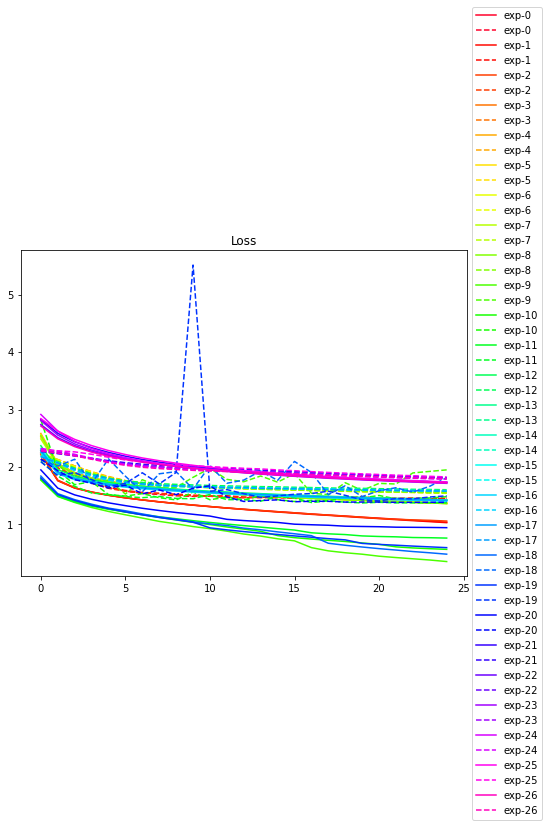

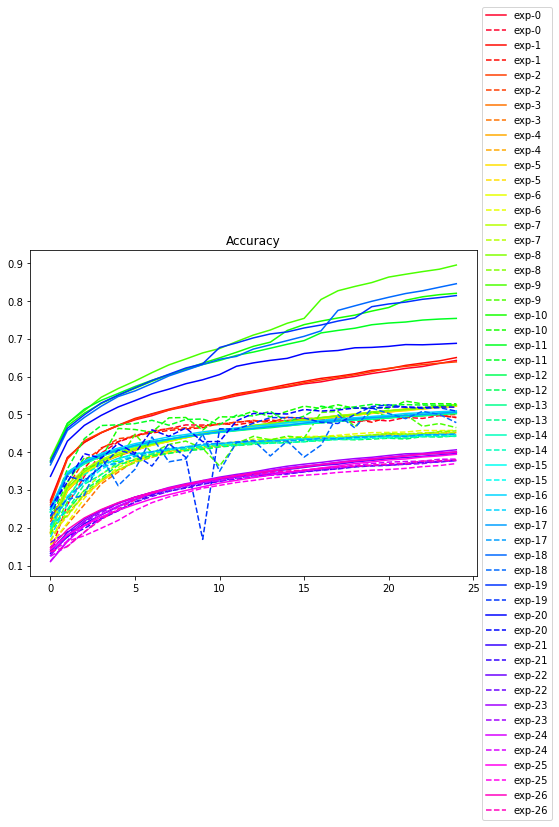

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()